# Classifying sequences using sequence metadata

Here, I present the example code that enables the classification of sequence types using only sequence metadata. As a general protocol, the following is applied to the original metadata:

1. **Sanitization (data wrangling):** here I replace strings such that all character separated strings have a common separator (in this case, a space character (` `) easier when constructing features from strings/string-separated numbers). Additionally, I also eliminate trailing spaces and convert all strings to lowercase

2. **Feature extraction:** 
    * **Data is a space-separated set of numbers:** extract the length, minimum, maximum, sum and mean of the sequence
    * **Data is a string:** use the `sklearn` feature extractor `CountVectorizer` for text - this counts the number of specific words appearing at each instance and one-hot encodes them

3. **Training/validating:** here I use a random forest as it generally performs better with tasks which are likely to be non-linear

## Library and data loading, defining relevant text and numeric columns

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import pydicom
import nltk
from glob import glob
from io import StringIO
from copy import deepcopy

data_path = "data/data_train.csv"
data = pd.read_csv(data_path)

from src.msc.constants import *

## Data sanitization

In [2]:
from src.msc.sanitization import *

data.loc[data["class"] == "DCE","class"] = "dce"
data = sanitize_data(data)

## Feature extraction

Here I implement a few classes (`SpaceSepNumColsToMatrix`, which converts space-separated strings of numbers into features, and `TextColsToNum` which uses `SpaceSepNumColsToMatrix` and `CountVectorizer` to extract features directly) that help me go from a relatively messy `pandas.Dataframe` to an orderly set of features.

In [3]:
from src.msc.feature_extraction import *

X = data.drop(cols_to_drop,axis=1)

study_uids = np.array(data["study_uid"].tolist())
y = np.array(data["class"])

When analysing these data I started noticing that a lot of it was missing in two particular columns - % phase field of view and SAR. First I assess the impact of removingn them (below).

In [4]:
print("Class composition before removing NaN in % phase field of view and SAR:",
      {k:c for k,c in zip(*np.unique(y,return_counts=True))})
not_nan_idxs = np.logical_and(
    X["percent_phase_field_of_view"]!="",X["sar"]!="")
X = X[not_nan_idxs]
y = y[not_nan_idxs]
study_uids = study_uids[not_nan_idxs]
print("Class composition after removing NaN in % phase field of view and SAR:",
      {k:c for k,c in zip(*np.unique(y,return_counts=True))})

Class composition before removing NaN in % phase field of view and SAR: {'adc': 5034, 'dce': 3113, 'dwi': 7493, 'others': 9965, 't2': 5727}
Class composition after removing NaN in % phase field of view and SAR: {'adc': 4464, 'dce': 3112, 'dwi': 7486, 'others': 9902, 't2': 5725}


Quite a bit of missing data, but mostly belonging to ADC - a sequence which is obtained using DWI. So surely one can use the % phase field of view and SAR values in DWI as replacements for missing in ADC. It should be noted that this is something we can easily do at both training and evaluation times as the presence of ADC sequences implies the existence of DWI sequences. For this reason, we perform this prior to any data splitting processes.

In essence, this works as a slightly more informed process of data imputation - rather than using the usual univariate (through mode/median/mean) or multivariate methods, we can be better informed by assuming some exchangeability in these regards.

In [5]:
data = sequence_to_other_df(
    data,"study_uid","class","dwi","adc","percent_phase_field_of_view")
data = sequence_to_other_df(
    data,"study_uid","class","dwi","adc","sar")

X = data.drop(cols_to_drop,axis=1)

study_uids = np.array(data["study_uid"].tolist())
y = np.array(data["class"])

print("Class composition before removing NaN in % phase field of view and SAR:",
      {k:c for k,c in zip(*np.unique(y,return_counts=True))})
not_nan_idxs = np.logical_and(
    X["percent_phase_field_of_view"]!="",X["sar"]!="")
X = X[not_nan_idxs]
y = y[not_nan_idxs]
study_uids = study_uids[not_nan_idxs]
print("Class composition after removing NaN in % phase field of view and SAR:",
      {k:c for k,c in zip(*np.unique(y,return_counts=True))})

Class composition before removing NaN in % phase field of view and SAR: {'adc': 5034, 'dce': 3113, 'dwi': 7493, 'others': 9965, 't2': 5727}
Class composition after removing NaN in % phase field of view and SAR: {'adc': 5031, 'dce': 3112, 'dwi': 7486, 'others': 9902, 't2': 5725}


Much better! Only a few instances lost when removing empty columns belonging to % phase field of view and SAR.

## Data exploration

We start by performing a simple data exploration using dimensionality reduction algorithms - PCA and t-SNE. For the latter it is very important to consider that distances are meaningless as the method seeks to only maintain the local neighourhood structure and does not optimize in any direct way for reproducing the distances between points in lower dimensions.

From what is observable below in the PCA (first and second plots), there seems to be some structure to the data, with some tendency for several regions to be populated by fairly different classes. However, it is important to note that the first two components of the PCA explain under 40% of the variance - this is quite a small fraction of the total variation of the data and, inspecting the t-SNE (third plot), obtained using 5,000 points, a different picture is revealed - indeed, while often spatially separated, there seems to be a consistent clustering of points belonging to the same class. This apparent lack of linearity as represented by the co-localisation of distinct classes in PCA and the consistent clustering of points in t-SNE points towards methods which can consider non-linear interactions between features as a more robust alternative.

In [6]:
count_vec = TextColsToCounts(
    text_cols={i:x for i,x in enumerate(X.columns) if x in text_sep_cols},
    text_num_cols={i:x for i,x in enumerate(X.columns) if x in num_sep_cols},
    num_cols={i:x for i,x in enumerate(X.columns) if x in num_cols})

out = count_vec.fit_transform(X)
print(out.shape)
nan_idxs = np.isnan(out).sum(1) > 0
out = out[~nan_idxs,:]
y_plot = y[~nan_idxs]
print(out.shape)

(31256, 456)
(31245, 456)


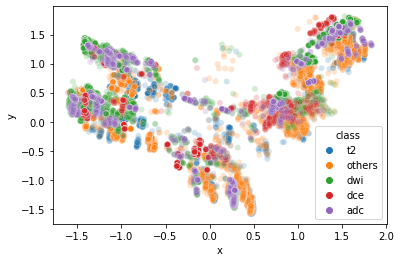

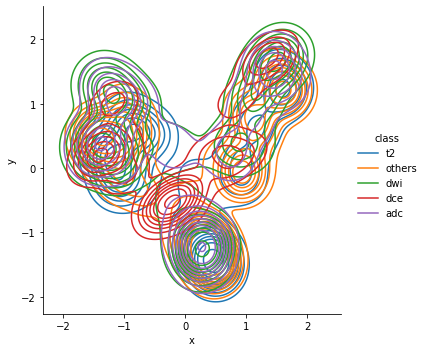

[0.18871008 0.16166623]


In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import minmax_scale
import seaborn as sb
import matplotlib.pyplot as plt

pca = PCA(whiten=True)
pca_out = pca.fit_transform(minmax_scale(out))
pc1,pc2 = pca_out[:,0],pca_out[:,1]

df_pca = pd.DataFrame.from_dict({"x":pc1,"y":pc2,"class":y_plot})
sb.scatterplot(data=df_pca,x="x",y="y",hue="class",alpha=0.2)
sb.displot(data=df_pca,x="x",y="y",hue="class",kind="kde")

plt.show()
print(pca.explained_variance_ratio_[:2])

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.002s...
[t-SNE] Computed neighbors for 5000 samples in 0.626s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.499887
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.176197
[t-SNE] KL divergence after 1000 iterations: 0.252293


<AxesSubplot:xlabel='x', ylabel='y'>

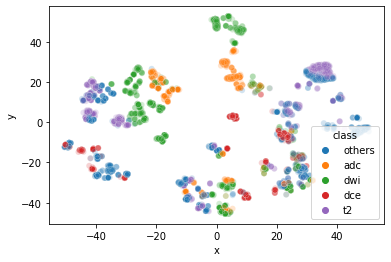

In [8]:
from sklearn.manifold import TSNE

tsne_subset = np.random.choice(out.shape[0],5000,replace=False)
tsne = TSNE(init='random',learning_rate='auto',
            verbose=True,perplexity=100)
tsne_out = tsne.fit_transform(minmax_scale(out[tsne_subset]))
tsne1,tsne2 = tsne_out[:,0],tsne_out[:,1]

df_tsne = pd.DataFrame.from_dict({"x":tsne1,"y":tsne2,"class":y_plot[tsne_subset]})
sb.scatterplot(data=df_tsne,x="x",y="y",hue="class",alpha=0.2)

## Training

### CV performance

In [9]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

n_folds = 5

kf = KFold(n_folds,shuffle=True,random_state=42)

nan_remover = RemoveNan()
unique_study_uids = list(set(study_uids))

f = 0

fold_results = []

model_dict = {
    "rf":{
        "model":RandomForestClassifier,
        "params":{"max_features":'sqrt'},
        "cv_params":{"max_depth":[None,10,20],"min_samples_split":[2,4,8]}
    },
    "elastic":{
        "model":SGDClassifier,
        "params":{"penalty":"elasticnet"},
        "cv_params":{"l1_ratio":[0.1,0.5,0.9,0.95,0.99]}
    },
    "extra_trees":{
        "model":ExtraTreesClassifier,
        "params":{"max_features":'sqrt'},
        "cv_params":{"max_depth":[None,10,20],"min_samples_split":[2,4,8]}
    },
    "xgb":{
        "model":XGBClassifier,
        "params":{"objective":"multi:softproba","n_jobs":2},
        "cv_params":{}
    }
}

model_dict_bayes = {
    "rf":{
        "model":RandomForestClassifier,
        "params":{},
        "cv_params":{"max_depth":Integer(3,20),
                     "min_samples_split":Integer(2,10)}
    },
    "elastic":{
        "model":SGDClassifier,
        "params":{"penalty":"elasticnet"},
        "cv_params":{"l1_ratio":Real(0,1)}
    },
    "extra_trees":{
        "model":ExtraTreesClassifier,
        "params":{},
        "cv_params":{"max_depth":Integer(3,20),
                     "min_samples_split":Integer(2,10)}
    },
}

model_name = "xgb"
bayesian = False

class_conversion = {'adc':0,'dce':1,'dwi':2,'others':3,'t2':4}

for train_idxs,val_idxs in kf.split(unique_study_uids):
    print("Fold {}".format(f+1))
    # data splitting
    train_uids = [unique_study_uids[i] for i in train_idxs]
    val_uids = [unique_study_uids[i] for i in val_idxs]
    train_idxs_long = [i for i,x in enumerate(study_uids) 
                       if x in train_uids]
    val_idxs_long = [i for i,x in enumerate(study_uids) 
                     if x in val_uids]
    training_X = X.iloc[train_idxs_long]
    training_y = y[train_idxs_long]
    val_X = X.iloc[val_idxs_long]
    val_y = y[val_idxs_long]

    print("\tTransforming data")
    count_vec = TextColsToCounts(
        text_cols={i:x for i,x in enumerate(X.columns) if x in text_sep_cols},
        text_num_cols={i:x for i,x in enumerate(X.columns) if x in num_sep_cols},
        num_cols={i:x for i,x in enumerate(X.columns) if x in num_cols})
    count_vec.fit(training_X)
    out = count_vec.transform(training_X)
    out_val = count_vec.transform(val_X)
    if model_name != "xgb":
        out,training_y = nan_remover.transform(out,training_y)
        out_val,val_y = nan_remover.transform(out_val,val_y)
    else:
        training_y = [class_conversion[x] for x in training_y]
        val_y = [class_conversion[x] for x in val_y]

    print("\tTraining model")
    if bayesian == True:
        md = model_dict_bayes
    else:
        md = model_dict

    p = Pipeline(
        [("remove_zero_var",VarianceThreshold()),
         ("model",md[model_name]["model"](**md[model_name]["params"]))]
    )

    if bayesian == True:
        search_fn = BayesSearchCV
    else:
        search_fn = GridSearchCV

    model = search_fn(
        p,
        {"model__"+k:md[model_name]["cv_params"][k]
            for k in md[model_name]["cv_params"]},
        verbose=0,n_jobs=4,cv=3,scoring="f1_macro")

    model.fit(out,training_y)

    print("\tEvaluating model")
    y_pred = model.predict(out_val)
    fold_results.append({
        "auc":roc_auc_score(val_y,model.predict_proba(out_val),
                            multi_class="ovr"),
        "count_vec":count_vec,
        "model":model,
        "y_true":val_y,
        "y_pred":y_pred,
        })
    
    f += 1

Fold 1
	Transforming data
	Training model
	Evaluating model
Fold 2
	Transforming data
	Training model
	Evaluating model
Fold 3
	Transforming data
	Training model
	Evaluating model
Fold 4
	Transforming data
	Training model
	Evaluating model
Fold 5
	Transforming data
	Training model
	Evaluating model


[0.9993913  0.99940312 0.99962022 0.99984967 0.99987409]


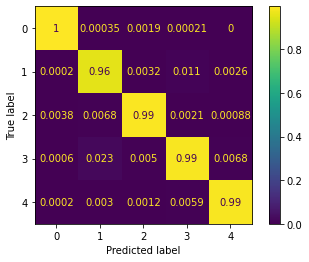

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cms = []
aucs = []
for f in fold_results:
    aucs.append(f["auc"])
    cm = confusion_matrix(f["y_true"],f["y_pred"])
    
    cm = cm / cm.sum(1)
    cms.append(cm)

print(np.quantile(aucs,[0,0.05,0.5,0.95,1.0]))
ConfusionMatrixDisplay(np.array(cms).mean(0),display_labels=f["model"].classes_).plot()
plt.show()

In [11]:
metric_dict = {"metric":[],"fold":[],"sequence_id":[],"value":[]}
for i,f in enumerate(fold_results):
    cr = classification_report(
        f["y_true"],f["y_pred"],
        output_dict=True)
    for k in cr:
        if isinstance(cr[k],dict):
            for kk in cr[k]:
                metric_dict["sequence_id"].append(k.upper())
                metric_dict["value"].append(cr[k][kk])
                metric_dict["metric"].append(kk)
                metric_dict["fold"].append(i)

metric_df = pd.DataFrame.from_dict(metric_dict)
metric_df

,metric,fold,sequence_id,value
0,precision,0,0,0.995069
1,recall,0,0,0.996051
2,f1-score,0,0,0.995560
3,support,0,0,1013.000000
4,precision,0,1,0.974958
...,...,...,...,...
135,support,4,MACRO AVG,6141.000000
136,precision,4,WEIGHTED AVG,0.981284
137,recall,4,WEIGHTED AVG,0.981273
138,f1-score,4,WEIGHTED AVG,0.981261


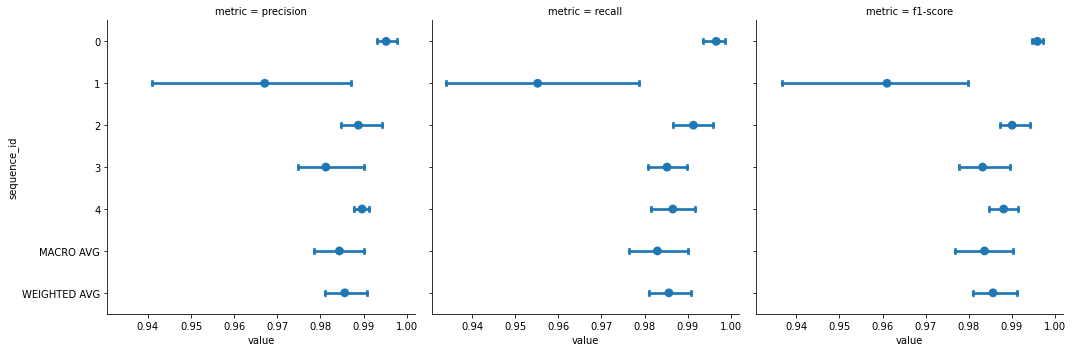

In [12]:
metric_df["idx"] = np.arange(metric_df.shape[0])
metric_df.pivot(["metric","fold"],"sequence_id","value").reset_index()

sb.catplot(data=metric_df[metric_df["metric"]!="support"],y="sequence_id",x="value",
           kind="point",col="metric",join=False,capsize=.1)

### Hold-out test set

In [13]:
test_data_path = "data/data_test.csv"
data_hold_out = pd.read_csv(test_data_path)
data_hold_out.loc[data_hold_out["class"] == "DCE","class"] = "dce"

data_hold_out = sanitize_data(data_hold_out)
data_hold_out = sequence_to_other_df(
    data_hold_out,"study_uid","class","dwi","adc","percent_phase_field_of_view")
data_hold_out = sequence_to_other_df(
    data_hold_out,"study_uid","class","dwi","adc","sar")

X_hold_out = data_hold_out.drop(cols_to_drop,axis=1)
y_hold_out = np.array(data_hold_out["class"])

In [18]:
all_predictions = {}

for i,f in enumerate(fold_results):
    count_vec = f["count_vec"]
    model = f["model"]
    test_data_pred = count_vec.transform(X_hold_out)
    test_data_pred,y_test = nan_remover.transform(test_data_pred,y_hold_out)
    if model_name == "xgb":
        y_test = [class_conversion[x] for x in y_test]

    y_pred = model.predict(test_data_pred)

    all_predictions[i] = {"true":y_test,"pred":y_pred,
                          "auc":roc_auc_score(y_test,model.predict_proba(test_data_pred),
                                              multi_class="ovr")}

[0.99971072 0.99971993 0.99978789 0.99981861 0.99982441]


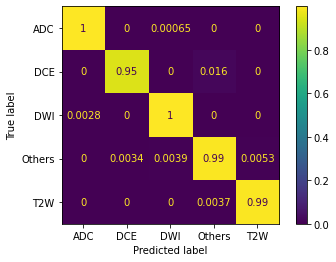

array([[0.999, 0.   , 0.001, 0.   , 0.   ],
       [0.   , 0.948, 0.   , 0.016, 0.   ],
       [0.003, 0.   , 0.998, 0.   , 0.   ],
       [0.   , 0.003, 0.004, 0.993, 0.005],
       [0.   , 0.   , 0.   , 0.004, 0.994]])

In [23]:
cms = []
aucs = []
l = ["ADC","DCE","DWI","Others","T2W"]
for i in all_predictions:
    f = all_predictions[i]
    aucs.append(f["auc"])
    cm = confusion_matrix(f["true"],f["pred"])
    
    cm = cm / cm.sum(1)
    cms.append(cm)

print(np.quantile(aucs,[0,0.05,0.5,0.95,1.0]))
ConfusionMatrixDisplay(np.array(cms).mean(0),display_labels=l).plot()
plt.show()

np.array(cms).mean(0).round(3)

In [24]:
hold_out_metric_dict = {"metric":[],"fold":[],"sequence_id":[],"value":[]}
for i in all_predictions:
    cr = classification_report(all_predictions[i]["true"],
                               all_predictions[i]["pred"],
                               output_dict=True)
    for k in cr:
        if isinstance(cr[k],dict):
            for kk in cr[k]:
                hold_out_metric_dict["sequence_id"].append(k.upper())
                hold_out_metric_dict["value"].append(cr[k][kk])
                hold_out_metric_dict["metric"].append(kk)
                hold_out_metric_dict["fold"].append(i)

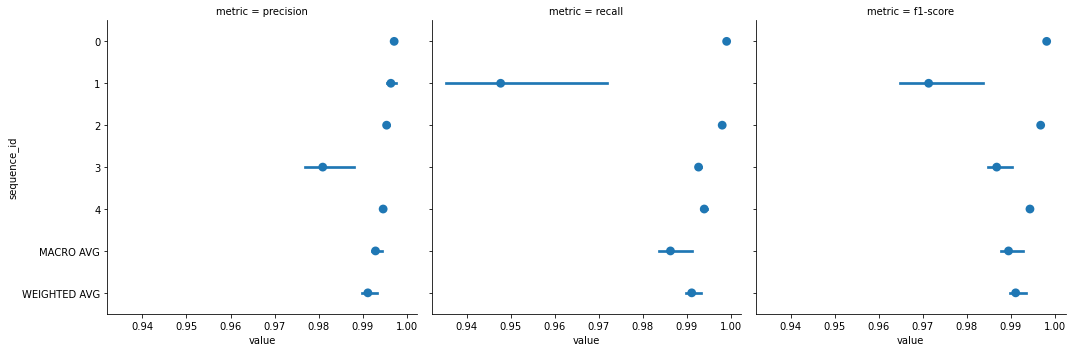

In [25]:
hold_out_metric_df = pd.DataFrame.from_dict(hold_out_metric_dict)

hold_out_metric_df["idx"] = np.arange(hold_out_metric_df.shape[0])
hold_out_metric_df.pivot(["metric","fold"],"sequence_id","value").reset_index()

sb.catplot(data=hold_out_metric_df[hold_out_metric_df["metric"]!="support"],y="sequence_id",x="value",
           kind="point",col="metric",join=False)